In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import torchvision
from PIL import Image as im
import torch.nn as nn
from torch.nn import Conv2d, Dropout
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
path_og = os.chdir("C:/Users/enriq/Desktop/comparativa_nn/FaceMask")
path_dataset = "C:/Users/enriq/Desktop/comparativa_nn/FaceMask/dataset/just_faces/"

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [2]:
#Estandarizar nombres de los archivos
path = 'dataset/just_faces/0/'
path2 = 'dataset/just_faces/1/'
try:
    i = 0
    for filename in os.listdir(path):
        
        os.rename(os.path.join(path,filename), os.path.join(path,str(i)+'.jpg'))
        i = i +1

    i2 = 0        
    for filename in os.listdir(path2):
        os.rename(os.path.join(path2,filename), os.path.join(path2,str(i2)+'.jpg'))
        i2 = i2 +1
except:
    print("Nombres cambiados")

Nombres cambiados


In [3]:
#Resize a 224x224
f = "C:/Users/enriq/Desktop/comparativa_nn/FaceMask/dataset/just_faces/0/"
for file in os.listdir(f):
    f_img = f+str(file)
    img = im.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)
    
f1 = "C:/Users/enriq/Desktop/comparativa_nn/FaceMask/dataset/just_faces/1/"
for file1 in os.listdir(f1):
    f_img1 = f1+str(file1)
    img1 = im.open(f_img1)
    img1 = img1.resize((224,224))
    img1.save(f_img1)

1339
0
<class 'tuple'>


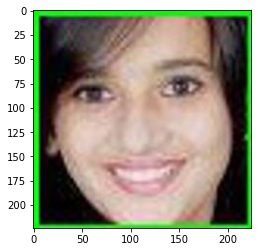

In [4]:
dataset = torchvision.datasets.ImageFolder(path_dataset)
print(len(dataset))
a =dataset[0]
print(a[1])
print(type(a))
plt.imshow(a[0])

In [5]:
transform = transforms.ToTensor()
lista=[]
df = pd.DataFrame()

for i in dataset:
    x=i[1]
    i=transform(i[0])
    lista.append([i,x])
#print(lista[800])

In [6]:
# Separamos en train y test
clases = ["Con", "Sin"]
train_data, test_data = torch.utils.data.random_split(lista, [686,653])

train_loader = DataLoader(train_data, batch_size=10, shuffle= True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle= True, pin_memory=True)
#print(train_data[0])

In [7]:
model = torchvision.models.GoogLeNet(num_classes=len(clases)).cuda()
model

C:\Users\enriq\anaconda3\envs\mlenv\lib\site-packages\torchvision\models\googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.cuda(), y_train.cuda()
        b+=1
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        y_pred = y_pred[0]
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%20 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/690]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            # Apply the model
            y_val = model(X_test)
            y_val = y_val[0]
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:  0  batch:   20 [   200/690]  loss: 0.05951781  accuracy:  88.000%
epoch:  0  batch:   40 [   400/690]  loss: 0.95206100  accuracy:  93.250%
epoch:  0  batch:   60 [   600/690]  loss: 0.04474917  accuracy:  93.333%
epoch:  1  batch:   20 [   200/690]  loss: 0.00262049  accuracy:  99.000%
epoch:  1  batch:   40 [   400/690]  loss: 0.69193703  accuracy:  98.500%
epoch:  1  batch:   60 [   600/690]  loss: 0.03546585  accuracy:  98.667%
epoch:  2  batch:   20 [   200/690]  loss: 0.00444282  accuracy:  99.500%
epoch:  2  batch:   40 [   400/690]  loss: 0.53640890  accuracy:  98.500%
epoch:  2  batch:   60 [   600/690]  loss: 0.03307658  accuracy:  98.500%
epoch:  3  batch:   20 [   200/690]  loss: 0.25077528  accuracy:  98.000%
epoch:  3  batch:   40 [   400/690]  loss: 0.20494315  accuracy:  97.750%
epoch:  3  batch:   60 [   600/690]  loss: 0.00675704  accuracy:  97.667%
epoch:  4  batch:   20 [   200/690]  loss: 0.04665198  accuracy:  98.000%
epoch:  4  batch:   40 [   400/690]  l

In [11]:
test_losses_item = []
print(test_losses)
for i in test_losses:
    print(i)
    test_losses_item.append(i.item())
test_losses_item

[tensor(0.0088, device='cuda:0'), tensor(0.0313, device='cuda:0'), tensor(0.0143, device='cuda:0'), tensor(0.0101, device='cuda:0'), tensor(0.0121, device='cuda:0')]
tensor(0.0088, device='cuda:0')
tensor(0.0313, device='cuda:0')
tensor(0.0143, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0121, device='cuda:0')


[0.00878858845680952,
 0.03129856660962105,
 0.01426666509360075,
 0.010055266320705414,
 0.012084651738405228]

[0.11872575432062149, 0.006608800496906042, 0.0014827148988842964, 0.1644633412361145, 0.007055098656564951]
[tensor(0.0088, device='cuda:0'), tensor(0.0313, device='cuda:0'), tensor(0.0143, device='cuda:0'), tensor(0.0101, device='cuda:0'), tensor(0.0121, device='cuda:0')]


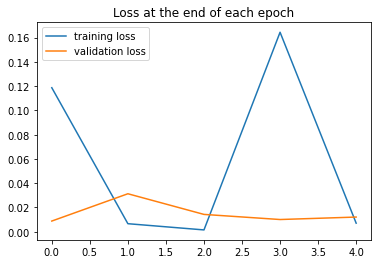

In [12]:
print(train_losses)
print(test_losses)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses_item, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [13]:
test_correct_item = []
print(test_correct)
for i in test_correct:
    print(i.item())
    test_correct_item.append(i.item())
test_correct_item

[tensor(630, device='cuda:0'), tensor(630, device='cuda:0'), tensor(638, device='cuda:0'), tensor(629, device='cuda:0'), tensor(642, device='cuda:0')]
630
630
638
629
642


[630, 630, 638, 629, 642]

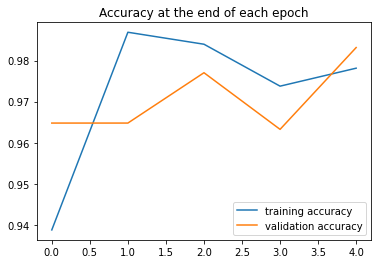

In [25]:
plt.plot([t/686 for t in train_correct], label='training accuracy')
plt.plot([t/653 for t in test_correct_item], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [15]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10, shuffle=False)

In [18]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.cuda(), y_test.cuda()
        y_val = model(X_test)  # we don't flatten the data this time
        y_val = y_val[0]
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 645/653 =  98.775%


In [19]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

0

In [20]:
# Set up an iterator to feed batched rows
r = 3   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

In [21]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
unloader = transforms.ToPILImage()  # reconvert into PIL image


In [22]:
def prediction_mascarilla(x):
    x = torch.tensor(x).cuda()
    #print(x.is_cuda)
    #print(test_data[x][0])
    image = test_data[x][0]
    #print(image.is_cuda)
    image = image.to(device)

    #print(image.is_cuda)
    #print(image.dtype)
    #print(image.type())

    imshow(image)
    model.eval()
    with torch.no_grad():
        new_pred = model(image.view(1,3,224,224)).argmax()
        if new_pred.item()==0:
            prediction = "Sin mascarilla"
        else:
            prediction = "Con mascarilla"
    print("Predicted value:",prediction)

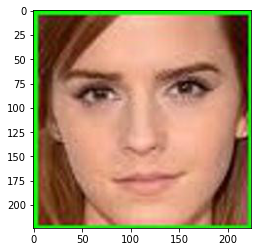

Predicted value: Sin mascarilla


In [24]:
prediction_mascarilla(0)